In [1]:
import numpy
import numba
from numba import jit

### Parameters

In [2]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

relax = 0.0
Up = 1.0

### Initial Relaxation Values for Vorticity field

In [3]:
def get_initial_psi(numx, numy, vrelax):
    psi_init = numpy.zeros((numy, numx))
    psi_init[:,:] = vrelax
    return psi_init

In [4]:
def get_initial_w(vpsi,numx, numy, delx, dely, vrelax):
    #
    w_init = numpy.zeros((numy, numx))
    w_init[:-1,:] = vrelax
    #
    w_init[1:-1,0] = -( 4*vpsi[1:-1,1] - 0.5*vpsi[1:-1,2] ) / ( delx**2 ) #x=0
    w_init[1:-1,-1] = - ( 4*vpsi[1:-1,-2] - 0.5*vpsi[1:-1,-3] ) / ( delx**2 ) #x=L
    w_init[0,1:-1] = - ( 4*vpsi[1,1:-1] - 0.5*vpsi[2,1:-1] ) / ( dely**2 ) # y=0
    w_init[-1,:] = -0.5*(8*vpsi[-2,:] - vpsi[-3,:])/(dely**2) - (3.0/dely)*(Up) #y=H
    return w_init

### Functions to compute vorticity and strem function

In [5]:
#@jit(nopython=True)
@jit

def get_streamfunction(vw, vpsi, numx, numy, delx, dely):   
    """
    computes the streamfunction field by gauss seidel
    
    vpsi - streamfunction
    vw - vorticity field
    numx, numy - grid points
    delx, dely - dx, dy
    """
    #w = vw.copy()
    #psi = vpsi.copy()
    #
    psi_new = numpy.zeros_like((vpsi))
    #
    for j in range(1,numy-1):
        for i in range(1,numx-1):
            psi_new[j,i] = 0.5*(1/(dely**2 + delx**2))*\
                      ( (vpsi[j,i-1] + vpsi[j,i+1])*(dely**2) +\
                        (vpsi[j-1,i] + vpsi[j+1,i])*(delx**2) +\
                         vw[j,i]*(delx**2)*(dely**2))
        
            #BCs:
            #
            psi_new[:-1,0] = 0.0 #x=0
            psi_new[:-1,-1] = 0.0 #x=L
            psi_new[0,1:-1] = 0.0 #y=0
            psi_new[-1,:] = 0.0 #y=L
            #
    return psi_new

In [6]:
#@jit(nopython=True)
@jit

def get_vorticity(vw, vpsi, numx, numy, delx, dely):
    """
    computes the vorticity field by gauss seidel
    
    vpsi - streamfunction
    vw - vorticity field
    numx, numy - grid points
    delx, dely - dx, dy
    """
    w_new = numpy.zeros_like((vw))
    #w = vw.copy()
    #psi = vpsi.copy()
    #
    for j in range(1,numy-1):
        for i in range(1,numx-1):
            w_new[j,i] = 0.5*(1/(dely**2 + delx**2))*\
                    ((vw[j,i-1] + vw[j,i+1])*(dely**2) +\
                     (vw[j-1,i] + vw[j+1,i])*(delx**2) )
        
        #BCs: 
        w_new[1:-1,0] = - ( 4*vpsi[1:-1,1] - 0.5*vpsi[1:-1,2] ) / ( delx**2 ) #x=0
        w_new[1:-1,-1] = - ( 4*vpsi[1:-1,-2] - 0.5*vpsi[1:-1,-3] ) / ( delx**2 ) #x=L
        w_new[0,1:-1] = - ( 4*vpsi[1,1:-1] - 0.5*vpsi[2,1:-1] ) / ( dely**2 ) # y=0
        w_new[-1,:] = -0.5*(8*vpsi[-2,:] - vpsi[-3,:])/(dely**2) - (3.0/dely)*(Up) #y=H
        #
    return w_new

In [7]:
psi_initial = get_initial_psi(nx, ny, relax)

In [8]:
w_initial = get_initial_w(psi_initial,nx, ny, dx, dy, relax) 

### L1 Norm function

In [9]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [10]:
#@jit(nopython=True)
@jit
def biharmonic_2d(w_init, psi_init, delx, dely, numx, numy, norm_target):
    """Computes the Biharmonic equation 
    vorticity and stream function equations are coupled
    
    psi_init - streamfunction initial values
    w_init - vorticity initial values
    delx - dx
    dely - dy
    """
    #
    iterations = 0.0
    w_norm = norm_target + 1
    psi_norm = norm_target + 1
    #
    w = w_init.copy()
    psi = psi_init.copy()
    #
    w_out = numpy.zeros((2772, numy, numx))
    psi_out = numpy.zeros((2772, numy, numx))
    #
    while (w_norm > norm_target) and (psi_norm > norm_target):
        wn = w.copy()
        psin = psi.copy()
        w = get_vorticity(wn, psin, numx, numy, delx, dely)
        psi = get_streamfunction(w, psin, numx, numy, delx, dely)
#         wn = w.copy()
#         psin = psi.copy()
#         psi = get_streamfunction(wn, psin, numx, numy, delx, dely)
#         w = get_vorticity(wn, psi, numx, numy, delx, dely)
       
        #
        iterations +=1
        w_norm = L1norm(w, wn)  #need to disengage numba because this depends on numpy
        psi_norm = L1norm(psi, psin)
        #
        w_out[iterations,:,:] = w.copy()
        psi_out[iterations,:,:] = psi.copy()
    #
    return psi_out, w_out, iterations

In [11]:
PSI, W, k = biharmonic_2d(w_initial, psi_initial, dx, dy, nx, ny, l1_target)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [12]:
k

2771.0

### Answers

What is the maximum value of |ψ| within the cavity when the solution has relaxed to the specified criteria? (specify to 4 decimal places)



In [13]:
PSI_max = numpy.max(numpy.abs(PSI[-1,:,:]))

In [14]:
PSI_max

0.099844725863709807

What is the maximum value of |ω| within the cavity when the solution has relaxed to the specified criteria? (specify to 4 decimal places)

In [15]:
W_max = numpy.max(numpy.abs(W[-1,1:,1:-1]))

In [16]:
W_max

78.192660960145787

In [17]:
numpy.round(PSI[-1,32,::8],4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

In [18]:
(PSI[-1,-1,1:-1]-PSI[-1,-2,1:-1])/dy

array([ 0.29304894,  0.53455437,  0.67199616,  0.74971394,  0.79735712,
        0.82923433,  0.85203166,  0.86908597,  0.88223153,  0.89257001,
        0.90080902,  0.90742519,  0.91275056,  0.91702198,  0.92041095,
        0.92304237,  0.92500671,  0.92636788,  0.92716838,  0.92743258,
        0.92716838,  0.92636788,  0.92500671,  0.92304237,  0.92041095,
        0.91702198,  0.91275056,  0.90742519,  0.90080902,  0.89257001,
        0.88223153,  0.86908597,  0.85203166,  0.82923433,  0.79735712,
        0.74971394,  0.67199616,  0.53455437,  0.29304894])

In [19]:
(3*PSI[-1,-1,1:-1]-4*PSI[-1,-2,1:-1]+PSI[-1,-3,1:-1])/(dy*2)

array([ 0.45908559,  0.76453228,  0.89652599,  0.94918598,  0.97126053,
        0.98169441,  0.98734047,  0.99075045,  0.99297185,  0.99449364,
        0.99557278,  0.99635689,  0.99693611,  0.99736792,  0.99769008,
        0.9979279 ,  0.99809846,  0.99821318,  0.99827932,  0.99830093,
        0.99827932,  0.99821318,  0.99809846,  0.9979279 ,  0.99769008,
        0.99736792,  0.99693611,  0.99635689,  0.99557278,  0.99449364,
        0.99297185,  0.99075045,  0.98734047,  0.98169441,  0.97126053,
        0.94918598,  0.89652599,  0.76453228,  0.45908559])

### Plot

In [20]:
from matplotlib import pyplot 

In [21]:
x = numpy.linspace(0,l,nx)
y = numpy.linspace(0,h,ny)
mx, my = numpy.meshgrid(x,y)

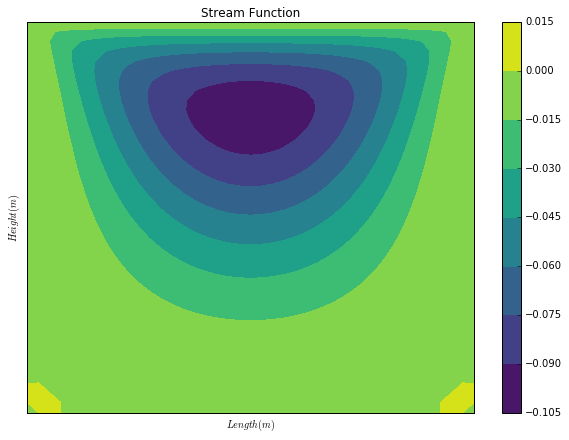

In [22]:
%matplotlib inline

fig = pyplot.figure(figsize=(10,7))

pyplot.contourf(mx,my,PSI[-1,:,:], cmap='viridis')
pyplot.xticks([]), pyplot.yticks([])
pyplot.xlabel('$Length (m)$')
pyplot.ylabel('$Height (m)$')
pyplot.colorbar()
pyplot.title('Stream Function');

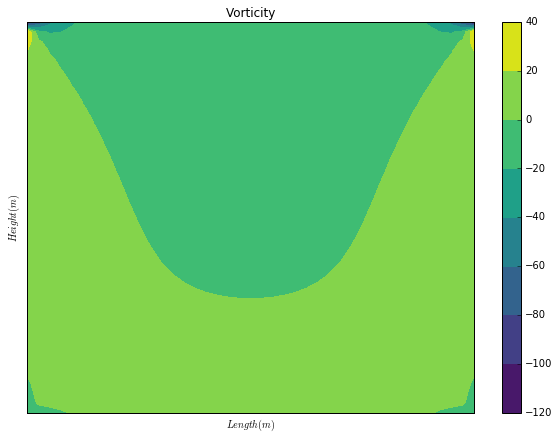

In [23]:
%matplotlib inline

fig = pyplot.figure(figsize=(10,7))

pyplot.contourf(mx,my,W[-1,:,:], cmap='viridis')
pyplot.xticks([]), pyplot.yticks([])
pyplot.xlabel('$Length (m)$')
pyplot.ylabel('$Height (m)$')
pyplot.colorbar()
pyplot.title('Vorticity');

In [24]:
# from matplotlib import animation
# from JSAnimation import IPython_display
# from JSAnimation.IPython_display import display_animation
# from moviepy.editor import *

# import pylab 
# import types

In [25]:
# ##############################################################

# #Use these animation functions:

# def animate(data):
#     im = ax.contourf(mx,my,data,cmap='viridis')
#     return im

In [26]:
# fig = pyplot.figure(figsize=(8,8))
# ax = pyplot.axes()
# im = ax.contourf(my, mx, PSI[0,:,:], cmap='viridis')



In [27]:
# anim = animation.FuncAnimation(fig, animate, frames=PSI[:k:25,:,:], interval=100)
# #to display:
# display_animation(anim, default_mode='once')